# Experiment Process
## Prepare HW
1. Switch supply power to mobile robot system
2. Turn on panda controller and mobile computer on the mobile system
3. Connect to Mobile WiFi (RNB-MOBILE, PW: robot!!!1)
4. Connect to Franka Desk (192.168.17.3) and unlock panda joints, make sure blue LED is on.

## Prepare Mobile Panda
1. Connect to mobile computer with AnyDesk (349 336 873)
    - Proceed this section in connected mobile computer.
2. Prepare SteamVR
    - Make sure Each Vive Base Station have unique ID (should be set in advance in Windows SteamVR)
    - Make sure Vive Base Stations are placed properly (facing each other)
    - Turn on vrmonitor
    - Connect Vive Tracker (Menu-Devices-Pair Controller)
    - Make sure All Base Station and Tracker icons are active
3. Start camera server
```bash
cd ~/Projects/grpc_cam/
python3 cam_grpc_server.py
```
    - If any error is raised, disconnect and reconnect camera 
4. Start panda control program
```bash
roslaunch panda_control joint_control_rnb.launch robot_ip:=192.168.17.3 load_gripper:=false
```
    - **[IMPORTANT]** enable data plot on web UI
5. Start mobile robot server
```bash
~/run_mobile_server.sh
```


## Proceed Experiment
* Place table, chair, clocks and target markers and run scripts below


## Trouble shooting
* **Panda stop**: panda controller can stop due to excessive  torque or network loss
    - push and turn panda activation button to reset state, and restart panda control program
* **Mobile robot stop**: mobile robot can raise error due to heavy load
    - ***TO BE DONE***
    
## NOTE
* Panda joint offset value backup:
 - [-0.01, -0.009, -0.022, 0.0, 0.007, -0.012, 0.0]

# 이슈
* 테이블이 왼쪽으로 치우쳐 찍히는 경향

# 테스트 기준
* 로봇의 제한된 자유도 고려, 원천적으로 해결 불가능한 문제는 아래의 조건 등을 통해 배제하였음.
  - 의자 간 거리는 1m 이상
  - 시계는 20cm 이상
  - 각 마커와 시계 사이에는 3cm 이상의 공백을 둠
* 위의 경우를 포함, 로봇이 해결할 수 없는 상황은 사람 작업자의 개입 요청으로 해결될 예정
* 사각 테두리 안쪽에 툴이 접촉하면 성공
* 각 플래닝은 최대 300초
* 동작 도중 환경 및 장애물에 충돌이 발생하면 실패

# 판다 플롯 시작!

# 실험 시작 - 사진 촬영!

In [1]:
QOFF_PANDA = [-0.01, -0.009, -0.022, 0.0, 0.007, -0.012, 0.0]

In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))

CONNECT_MOBILE = True
CONNECT_ROBOT = True
SAVE_DATA = False

MOBILE_IP = "192.168.17.2"
ROBOT_IP = "192.168.17.2"
PANDA_IP = "192.168.17.3"

print("Mobile IP: {}".format(MOBILE_IP))
print("ROBOT  IP: {}".format(ROBOT_IP))
print("PANDA  IP: {}".format(PANDA_IP))

sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/developing/multiobject'))

from concurrent import futures
import logging
import math
import time
import cv2
import numpy as np
import grpc
import RemoteCam_pb2
import RemoteCam_pb2_grpc

MAX_MESSAGE_LENGTH = 10000000
PORT_CAM = 10509

Mobile IP: 192.168.17.2
ROBOT  IP: 192.168.17.2
PANDA  IP: 192.168.17.3


In [3]:
ROBOT_BASE_OFFSET = (+0.02-0.035-0.15+0.008,0,0.592)
ROBOT_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001
WS_HEIGHT = 1.7
COL_COLOR = (1,1,1,0.2)
    
LOG_FORCE = False

from pkg.controller.combined_robot import *
from pkg.project_config import *

kiro_udp_client.KIRO_UDP_OFFLINE_DEBUG = not CONNECT_MOBILE

mobile_config = RobotConfig(0, RobotType.pmb, ((0,0,0), (0,0,0)), MOBILE_IP)
robot_config = RobotConfig(1, RobotType.panda_arm, 
                           (ROBOT_BASE_OFFSET, ROBOT_BASE_RPY),
                           "{}/{}".format(ROBOT_IP, PANDA_IP), root_on="pmb0_platform")

ROBOT_TYPE = robot_config.type
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config],
                     connection_list=[CONNECT_MOBILE, CONNECT_ROBOT])

connection command:
pmb0: True
panda_arm1: True


### Make scene

In [4]:
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.planning.scene import PlanningScene

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)
gtems = s_builder.add_robot_geometries(
    color=COL_COLOR, display=True, collision=True)

gscene.set_workspace_boundary(
    -1, 4, -2.5, 2.5, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS)

HOME_POSE_DEFAULT = np.copy(crob.home_pose)
gscene.show_pose(crob.home_pose)
crob.simulator.gscene=gscene

Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


### Planning scene

In [5]:
from pkg.geometry.geometry import *
from pkg.utils.code_scraps import *
from pkg.planning.constraint.constraint_subject import *
from pkg.planning.constraint.constraint_actor import *
from exp_config import *

pscene = PlanningScene(gscene, combined_robot=crob)

In [6]:
ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE
BRUSH_NAME = "brush_face"
theta = -np.pi*3/4
viewpoint  = add_panda_cam(gscene, tool_link=TIP_LINK, theta=theta)
brush_face = add_panda_brush(gscene, tool_link=TIP_LINK, theta=theta, 
                             brush_name=BRUSH_NAME)

point_brush, rpy_brush = (0,0,-brush_face.dims[2]/2), (0,0,0)
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayFramer, point=point_brush, rpy=rpy_brush)
gscene.show_pose(HOME_POSE_DEFAULT)

MOBILE_PUSH_NAME = "mpush"
MOBILE_PUSH_HEIGHT = 0.4
MOBILE_PUSH_KEY = 1
MOBILE_SLIDE_KEY = 2
front_dist = 0.03
mpush_g = gscene.create_safe(GEOTYPE.SPHERE, MOBILE_PUSH_NAME, link_name=HOLD_LINK,dims=(0.01,0.01,0.01),
                           center=(front_dist, 0, MOBILE_PUSH_HEIGHT), rpy=(0,np.pi/2,0),
                           fixed=True, collision=False, color=(1,0,0,0.5))
mpush_b = pscene.create_binder(MOBILE_PUSH_NAME, MOBILE_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=MOBILE_PUSH_KEY)

floor_b = pscene.create_binder("floor_ws", "floor_ws", PlaceFrame, point=(0,0,WALL_THICKNESS/2), key=MOBILE_SLIDE_KEY)

TOOL_PUSH_NAME = "tpush"
TOOL_PUSH_KEY = 10
TOOL_SLIDE_KEY = 11
brush_col = gscene.NAME_DICT[BRUSH_NAME+"_col"]
TOOL_DIM = brush_col.dims

center_push, rpy_push = (TOOL_DIM[0]/2+CLEARANCE, 0, 0), (0,np.pi/2,0)    
tpush_g = gscene.create_safe(GEOTYPE.SPHERE, TOOL_PUSH_NAME, link_name=TIP_LINK,dims=(0.01,0.01,0.01),
                           center=center_push, rpy=rpy_push,
                           fixed=True, collision=False, color=(1,0,0,0.5), parent=BRUSH_NAME)
tpush_b = pscene.create_binder(TOOL_PUSH_NAME, TOOL_PUSH_NAME, FramedTool, point=(0,0,0), rpy=(0,0,0), key=TOOL_PUSH_KEY)

# Start detecting - set joint offset

In [7]:
from pkg.controller.trajectory_client.web_client import *
wc = WebClient(ip='192.168.17.2', port=9990)

In [8]:
wc.change_gain(**{"q_off{}".format(i_q): q_off_val for i_q, q_off_val in enumerate(QOFF_PANDA)})

URI sent: http://192.168.17.2:9990/param_setting?q_off6=0.0&q_off5=-0.012&q_off4=0.007&q_off3=0.0&q_off2=-0.022&q_off1=-0.009&q_off0=-0.01


### MultiICP Detector

In [9]:
from pkg.detector.multiICP.multiICP import MultiICP, MultiICP_Obj
from pkg.detector.multiICP.config import *
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

import open3d as o3d
import numpy as np

CONNECT_CAM = False
REMOTE_CAM = True

CARRIER_DIM = (0.4, 0.29, 0.635)
CLOCK_DIM = (0.138, 0.05, 0.078)

In [10]:
from demo_utils.data_reconstructed_camera import DataRecontructedCamera
dcam = DataRecontructedCamera(crob, viewpoint)
# if not CONNECT_CAM and not REMOTE_CAM:
#     dcam.initialize()

if CONNECT_CAM:
    realsense = RealSense()
    micp = MultiICP(realsense)
    micp.initialize()
else:
    if REMOTE_CAM:
        # use remote camera
        micp = MultiICP(None)
        micp.initialize(remote_cam=REMOTE_CAM)
#         dcam.ready_saving(*micp.get_camera_config())
#         cam_pose = viewpoint.get_tf(VIEW_POSE_EXT)
    else:
        # use manually given camera configs
        micp = MultiICP(None)
        config_list, img_dim = load_pickle(RNB_PLANNING_DIR+"release/multiICP_data/cam_configs.pkl")
        micp.initialize(config_list, img_dim)
#         micp = MultiICP(dcam)
#         micp.initialize()

Camera is not set - skip initialization, use remote camera
request 0 -> response 0
==== Received camera config from remote camera ====


### Shared Detector

In [11]:
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")

from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(tuple(reversed(micp.dsize))+(3,))()
sd.init()

### Set ICP Config

In [12]:
# Load config file of object information
obj_info_dict = get_obj_info()

In [13]:
micp_suitcase = MultiICP_Obj(obj_info_dict["suitcase"], None,
                        OffsetOnModelCoord("suitcase", R=np.matmul(Rot_axis(1, 2*np.pi/3), Rot_axis(3, np.pi/2)), offset=(0.,0.,0.2)))


micp_clock = MultiICP_Obj(obj_info_dict["clock"], None,
                        OffsetOnModelCoord("clock", R=Rot_axis(1, np.pi/4), offset=(-0.04,-0.03,0.04)))


micp_table = MultiICP_Obj(obj_info_dict["dining table"], None,
                        OffsetOnModelCoord("dining table", R=Rot_axis(1, 3*np.pi/4), offset=(0.,0.35,0.6)))

micp_chair = MultiICP_Obj(obj_info_dict["chair"], None,
                        OffsetOnModelCoord("chair", R=Rot_axis(1, 3*np.pi/4), offset=(0.1, 0.1,0.)))

In [14]:
micp_dict = {"suitcase": micp_suitcase, "clock": micp_clock,
             "dining table": micp_table, "chair": micp_chair}
micp.set_config(micp_dict, sd, crob, viewpoint)

## Table

In [51]:
VIEW_LOC = crob.get_real_robot_pose()[:6]
VIEW_ARM = HOME_POSE_DEFAULT[6:] + np.deg2rad([0,0,0,0,0,45,-45])
VIEW_TABLE = list(VIEW_LOC) + list(VIEW_ARM)
crob.joint_move_make_sure(np.array(VIEW_TABLE), ref_speed=np.pi/8)

In [52]:
TABLE_NAME = "table"

In [54]:
# for dining table
micp.set_ICP_thres(thres_ICP=0.6, thres_front_ICP=0.18)
micp.set_pcd_ratio(ratio=0.5)
micp.set_inlier_ratio(ratio=0.02)
# micp.set_multiobject_num(num = 1)
micp.set_merge_mask(merge=True)
pose_dict = micp.detect(name_mask=["dining table"], visualize=True)

name_mask is ['dining table']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 1
===== Detected : dining table, 2 object(s) =====
[NOTICE] You choose merge option for mask. Detected masks would be merged.

'dining table' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.785714e-01, inlier_rmse=2.970279e-01, and correspondence_set size of 274
Access transformation to get result.
Transformation is:
[[ 0.74663267  0.16715504  0.6438935   0.14678418]
 [ 0.6280935  -0.49603317 -0.59954118  0.15516058]
 [ 0.21917621  0.85206235 -0.47534356  3.55352983]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.74663267  0.16715504  0.6438935   0.14678418]
 [ 0.6280935  -0.49603317 -0.59954118  0.15516058]
 [ 0.21917621  0.85206235 -0.47534356  3.55352983]
 [ 0.          0.          0.          1.        ]]
Inlier ratio: 

In [18]:
# add table
center, rpy = pose_refine("dining table", pose_dict["dining table_1"])
table_vis, table_g = add_table(gscene, TABLE_NAME, center, rpy)
TABLE_HEIGHT = table_g.center[2] + table_g.dims[2]/2

In [19]:
table_b = pscene.create_binder(TABLE_NAME, TABLE_NAME, PlaceFrame, point=(0,0,table_g.dims[2]/2), key=TOOL_SLIDE_KEY)
# gscene.add_virtual_guardrail(table_g, HEIGHT=0.01, axis="xy")

### update workspace

In [20]:
Tbt = table_g.get_tf(HOME_POSE_DEFAULT)
Tbm = gscene.get_tf(MOBILE_BASE, VIEW_TABLE)
Ttm = np.matmul(np.linalg.inv(Tbt), Tbm)

Ymax = table_g.dims[1]/2
Ymin = Ttm[1,3]-0.9
Xmax = Ttm[0,3]+0.8
Xmin = -table_g.dims[0]/2-0.3
Xtc = np.mean([Xmax, Xmin])
Ytc = np.mean([Ymax, Ymin])
dX = Xmax - Xmin
dY = Ymax - Ymin
Xbc, Ybc, _, _ = np.matmul(Tbt, [Xtc, Ytc, 0, 1])
Xmax, Xmin = Xbc + dX/2, Xbc - dX/2
Ymax, Ymin = Ybc + dY/2, Ybc - dY/2

gscene.set_workspace_boundary(
    Xmin, Xmax, Ymin, Ymax, -CLEARANCE, WS_HEIGHT, thickness=WALL_THICKNESS, 
    RPY=Rot2rpy(Tbt[:3,:3]))

In [21]:
floor_ws = gscene.NAME_DICT["floor_ws"]
gscene.create_safe(GEOTYPE.BOX, "obstacle_corner", link_name="base_link",
                   dims = (0.5,0.5,1), 
                   center=(floor_ws.dims[0]/2-0.3, floor_ws.dims[1]/2-0.3, 0.5), 
                  display=True, collision=True, parent="floor_ws",
                  color=(1,1,0,0.2))

#### [SAVE DATA]

In [22]:
if SAVE_DATA:
    color, depth, Qcur = micp.get_image()
    cam_pose = viewpoint.get_tf(Qcur)
    dcam.ready_saving(*micp.get_camera_config())
    dcam.save_scene(color, depth, cam_pose)

### Chair

In [33]:
for i in range(10):
    try:
        gscene.remove(gscene.NAME_DICT["chair_{}".format(i)])
    except:
        pass

In [34]:
panda_arm1 = crob.robot_dict["panda_arm1"]
img_list = []
for theta0 in [-30, 0, 30]:
    VIEW_LOC = crob.get_real_robot_pose()[:6]
#     VIEW_ARM = HOME_POSE_DEFAULT[6:] + np.deg2rad([theta0,-45,0,-70,0,70,-45])
    VIEW_ARM = HOME_POSE_DEFAULT[6:] + np.deg2rad([theta0,-55,0,-65,0,45,-45])
    VIEW_CHAIR = list(VIEW_LOC) + list(VIEW_ARM)
    
    crob.joint_move_make_sure(np.array(VIEW_CHAIR), ref_speed=np.pi/8)
    
    time.sleep(0.5)
    
    # for chair
    micp.set_ICP_thres(thres_ICP=0.3, thres_front_ICP=0.08)
    micp.set_pcd_ratio(ratio=1)
    micp.set_inlier_ratio(ratio=0.05)
    micp.set_multiobject_num(num = 5)
    micp.set_outlier_removal(nb_points=18, radius=0.05)
    # micp.set_merge_mask(merge=True)
    pose_dict = micp.detect(name_mask=["chair"], visualize=True)
    
    # add or update suitcase
    add_update_object(gscene, crob, "chair", pose_dict, separate_dist=0.28, height = 0)
    
    color, depth = micp.last_input[:2]
    Qcur = crob.get_real_robot_pose()
    
    img_list.append((color, depth))
    
    # save data
    if SAVE_DATA:
        cam_pose = viewpoint.get_tf(Qcur)
        dcam.ready_saving(*micp.get_camera_config())
        dcam.save_scene(color, depth, cam_pose)

name_mask is ['chair']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 5
===== Detected : chair, 1 object(s) =====

'chair' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=5.862655e-02, and correspondence_set size of 20793
Access transformation to get result.
Transformation is:
[[ 9.99911845e-01  8.87015522e-03  9.88038726e-03 -1.40761539e-02]
 [ 1.32318056e-02 -6.03737566e-01 -7.97073294e-01  1.01125308e-01]
 [-1.10500292e-03  7.97133764e-01 -6.03801712e-01  2.27444236e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Total ICP Transformation is:
[[ 9.99911845e-01  8.87015522e-03  9.88038726e-03 -1.40761539e-02]
 [ 1.32318056e-02 -6.03737566e-01 -7.97073294e-01  1.01125308e-01]
 [-1.10500292e-03  7.97133764e-01 -6.03801712e-01  2.27444236e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+0

===== Detected : chair, 5 object(s) =====
[WARN] Not obtained point cloud of object

'chair' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=3.647129e-02, and correspondence_set size of 27806
Access transformation to get result.
Transformation is:
[[ 0.84964719 -0.52360181 -0.06277568  0.79393819]
 [-0.35112743 -0.47288395 -0.80814001  0.2491787 ]
 [ 0.39345798  0.70867615 -0.58563548  2.04619051]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.84964719 -0.52360181 -0.06277568  0.79393819]
 [-0.35112743 -0.47288395 -0.80814001  0.2491787 ]
 [ 0.39345798  0.70867615 -0.58563548  2.04619051]
 [ 0.          0.          0.          1.        ]]
Inlier ratio: 0.219964028777
initial: 
[[ 0.85 -0.52 -0.06  0.79]
 [-0.35 -0.47 -0.81  0.25]
 [ 0.39  0.71 -0.59  2.05]
 [ 0.    0.    0.    1.  ]]
Apply point-to-point ICP
registration::RegistrationResult with

In [35]:
gcol_names = sorted([gname for gname in gscene.NAME_DICT.keys() 
                 if "chair" in gname and "col" in gname])
chair_names = []

for gcol_name in gcol_names:
    chair_col_g = gscene.NAME_DICT[gcol_name]
    chair_g = gscene.NAME_DICT[chair_col_g.parent]
    chair_dim = chair_col_g.dims
    chair_name = chair_g.name
    chair_names.append(chair_name)
    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([3, 2], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(chair_dim, -R[:,2])/2, 4)
        point[2] = MOBILE_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, chair_g, point=point, rpy=Rot2rpy(R), key=MOBILE_PUSH_KEY))

    slide_point = SlidePoint("bottom_p", chair_g, point=(0,0,-CLEARANCE), rpy=(0,0,0), 
                                               binded_on=floor_b, dist_push_min=0.1, dist_push_max=1.0, key=MOBILE_SLIDE_KEY)

    chair_s = pscene.create_subject(oname=chair_name, gname=chair_name, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Add  ref waypoint

In [36]:
table_body = gscene.NAME_DICT[TABLE_NAME]

WP_NAME = "wp_0"
WP_DIM = (0.1,0.1,0.01)
WP_LOC = (0, -0.2, table_body.dims[2]/2+WP_DIM[2]/2)
WP_RPY = (0,0,np.pi/2)

wp_g = gscene.create_safe(GEOTYPE.BOX, WP_NAME, link_name="base_link", 
                          dims=WP_DIM,
                          center=(WP_LOC[0], WP_LOC[1], WP_LOC[2]), rpy=WP_RPY,
                          fixed=True, collision=True, color=(0.0,0.0,0.8,1), parent=TABLE_NAME)

waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     wp_g.name: WayFrame(
                                         wp_g.name, wp_g, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                 })

### prepare planner

In [37]:
from pkg.planning.filtering.grasp_filter import GraspChecker
from pkg.planning.filtering.reach_filter import ReachChecker
gcheck = GraspChecker(pscene)
rcheck = ReachChecker(pscene)

from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
mplan = MoveitPlanner(pscene, enable_dual=False)
mplan.update_gscene()
mplan.incremental_constraint_motion = True

from pkg.planning.incremental_search import *
# joint motion is not allowed when pusing object with holder
idc_push = np.where([stype == PushObject for stype in pscene.subject_type_list])[0]
inc = IncrementalSearch(pscene, gcheck, rcheck, 
                        explicit_rule= lambda pscene, node, leaf: not any([node[idx]==leaf[idx] and "push" in node[idx] for idx in idc_push]))
inc.prepare()
inc.set_motion_planner(mplan)

cresv = CollisionResolver(inc, gcheck)
rresv = ReachResolver(inc, rcheck, mplan, floor=floor_b.geometry, N_try_max=100)
mresv = MotionResolver(inc, mplan)
inc.resolver_stack = [cresv, rresv, mresv]

from pkg.ui.ui_broker import *
# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(inc, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

[WARN] reach data is not ready for pmb. Ignoring this robot...


Process PriorityQueueManager-12:
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 270, in _bootstrap
    util._exit_function()
  File "/usr/lib/python2.7/multiprocessing/util.py", line 308, in _exit_function
    _run_finalizers(0)
  File "/usr/lib/python2.7/multiprocessing/util.py", line 277, in _run_finalizers
    finalizer()
  File "/usr/lib/python2.7/multiprocessing/util.py", line 207, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 807, in _decref
    conn = _Client(token.address, authkey=authkey)
  File "/usr/lib/python2.7/multiprocessing/connection.py", line 175, in Client
    answer_challenge(c, authkey)
  File "/usr/lib/python2.7/multiprocessing/connection.py", line 432, in answer_challenge
    message = connection.recv_bytes(256)         # reject large message
KeyboardInterrupt


### Initialize State

In [38]:
gscene.show_pose(VIEW_TABLE)
chain_list = \
    [BindingChain(chair_name, "bottom_p", "floor_ws", "floor_ws") for chair_name in chair_names] \
    + [BindingChain("waypoints", None, None, None)]
# chain_list = \
#     [BindingChain(bag_name, "bottom_p", "floor_ws", "floor_ws") for chair_name in chair_names] \
#     + [BindingChain(clock_name, "bottom_p", "table", "table") for clock_name in clock_names] \
#     + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(VIEW_TABLE, chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

['chair_0', 'chair_1', 'chair_2', 'chair_3', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


## Custom planner

In [39]:
from nonholonomic_planner import *

nhp = NonHolonomicPlanner(mplan, MOBILE_NAME, min_radi=MIN_RADI_DEFAULT)
def custom_planner(group_name, tool_link, goal_pose, target_link, from_Q,
                   timeout=1, **kwargs):
    if group_name == MOBILE_NAME:
        Tbm = np.matmul(gscene.get_tf(target_link, from_Q), 
                        T_xyzquat((goal_pose[:3], goal_pose[3:])))
        to_Q = Tbm[:2, 3].tolist()+[Rot2axis(Tbm[:3,:3], 3)]
        traj = nhp.search(from_Q, to_Q, timeout=timeout, update_gscene=False)
        return traj, traj is not None
    else:
        return mplan.planner.plan_py(group_name, tool_link, goal_pose, target_link, from_Q,
                       timeout=1, **kwargs)
    
def custom_planner_joint(group_name, goal_state, Q_init, timeout=1, **kwargs):
    if group_name == MOBILE_NAME:
        custom_planner_joint.args = (group_name, goal_state, Q_init, timeout)
        custom_planner_joint.kwargs = kwargs
        traj = nhp.search(Q_init, goal_state[:3], timeout=timeout, update_gscene=False)
#         if traj is None:
#             raise(RuntimeError("fail"))
        return traj, traj is not None
    else:
        return mplan.planner.plan_joint_motion_py(group_name, goal_state, Q_init, timeout=1, **kwargs)
    
mplan.custom_planner = custom_planner
mplan.custom_planner_joint = custom_planner_joint

In [40]:
crob.home_pose = initial_state.Q
crob.home_dict = list2dict(crob.home_pose, crob.joint_names)

In [41]:
time_start = time.time()
DEBUG = False
inc.prepare()
from_state = initial_state.copy(pscene)
goal_nodes = [initial_state.node[:-1]+(1,)]

inc.search(from_state, goal_nodes, max_solution_count=1,
           verbose=DEBUG, display=DEBUG, dt_vis=0.001, 
           timeout=0.5, timeout_loop=100, 
           multiprocess=not DEBUG, add_homing=False)
time_approach_planning = time.time() - time_start

Use 10/20 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue

### Get snode schedule

In [42]:
snode_schedule = inc.get_best_schedule(at_home=False)
snode_schedule_move = []
for snode in snode_schedule:
    if snode.state.node[-1] != 0:
        break
    snode_schedule_move.append(snode)
len(snode_schedule_move)

4

### play schedule

In [43]:
pscene.set_object_state(initial_state)
gscene.show_pose(initial_state.Q)

In [44]:
snode_schedule_cvt = snode_schedule_move
inc.play_schedule(snode_schedule_cvt, period=0.01)
pscene.set_object_state(snode_schedule_cvt[-1].state)

('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('mpush', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 0)


#### make trajectory safe

In [45]:
vel_lims, acc_lims, dt_step = 0.5, 0.5, 0.02
snode_schedule_safe = [snode_schedule_cvt[0].copy(pscene)]
for snode, snode_pre in zip(snode_schedule_cvt[1:], snode_schedule_cvt[:-1]):
    snames, _ = pscene.get_changing_subjects(snode.state, snode_pre.state)
    if len(snames) > 1:
        raise(RuntimeError("More than 1 subject change - {}".format(snames)))
    if len(snames) == 1:
        subject = pscene.subject_dict[snames[0]]
    else:
        subject = None
        
    snode_cp = snode.copy(pscene)
    rpairs = crob.get_robots_in_act(snode_cp.traj)
    for rname, robot in rpairs:
        if rname == ROBOT_NAME:
            traj_simp = simplify_traj(snode.traj)
            snode_cp.set_traj(calc_safe_trajectory(
                dt_step, traj_simp, vel_lims=vel_lims, acc_lims=acc_lims)[1])
            break
    snode_cp.traj[:,6:] -= QOFF_PANDA
    snode_cp.state.Q[6:] -= QOFF_PANDA
    snode_schedule_safe.append(snode_cp)

## Execute schedule

## ForceModeSwitcher

In [46]:
def down_custom_log(ip_addr, JOINT_DOF, UI_PORT=9990, DT=1.0 / 2e3):
    uri = "http://{ip_addr}:{UI_PORT}/download_log".format(ip_addr=ip_addr, UI_PORT=UI_PORT)
    print(uri)
    log_dat = requests.get(uri)
    dat = log_dat.text
    lines = dat.split("\n")
    heads = lines[0].split(",")[:-1]
    data_mat = []
    for line in lines[1:]:
        data_line = list(map(float, line.split(",")[:-1]))
        if len(data_line) > 0:
            data_mat.append(data_line)
    data_mat = np.array(data_mat)
    Fext = data_mat[:, JOINT_DOF * 6+6:JOINT_DOF * 7+6]
    Fext = Fext[-int(10.0 / DT):]
    # idx_peak = np.argmax(Fext[:, 2])
    # print("peak: {}".format(np.round(Fext[idx_peak, 2], 1)))
    # Fext = Fext[idx_peak + int(1.0 / DT):idx_peak + int(4.0 / DT), 2]
    # print("force min/max: {} / {} in {}".format(np.round(np.min(Fext), 1), np.round(np.max(Fext), 1), len(Fext)))
    return Fext

class SimpleForceModeSwitcher(ModeSwitcherTemplate):
    def __init__(self, pscene, rname, crob, web_client, force_delay=5, switch_delay=0.5, log_force=False, DT=1.0 / 1e3):
        ModeSwitcherTemplate.__init__(self, pscene, switch_delay=switch_delay)
        self.crob = crob
        self.web_client = web_client
        self.DT = DT
        self.log_force = log_force
        self.force_log = []
        self.rname =rname
        self.robot = self.crob.robot_dict[rname]
        self.force_delay = force_delay

    def switch_in(self, snode_pre, snode_new):
        switch_state = False
        for stype, n1, n2 in zip(
                pscene.subject_type_list, snode_pre.state.node, snode_new.state.node):
            if stype==WaypointTask and n2>n1:
                switch_state = True
                break
        return switch_state

    def switch_out(self, switch_state, snode_new):
        if switch_state:
            self.web_client.change_controller("Hybrid_Null")
            sleep(self.switch_delay)
            self.web_client.change_gain(switch_control0=1)
            
            sleep(self.force_delay)

            self.robot.reset()
            sleep(self.switch_delay)
            self.web_client.change_gain(switch_control0=0)
            sleep(self.switch_delay)
            self.web_client.change_controller("NRIC_PD")
            
            Qrobot = snode_new.state.Q[self.crob.idx_dict[self.rname]]
            self.robot.joint_move_make_sure(Qrobot, ref_speed=np.pi / 36)  # return planned trajectory

            if self.log_force:
                sleep(self.switch_delay)
                Fext = down_custom_log(self.robot.server_ip, len(self.crob.idx_dict[self.rname]), DT=self.DT)
                self.force_log.append(Fext)

In [47]:
mode_switcher = SimpleForceModeSwitcher(pscene, ROBOT_NAME, crob, wc, 
                                        force_delay=5, switch_delay=1, 
                                        log_force=False, DT=1.0/1e3)

### Start moving - set joint offset 0

In [48]:
wc.change_gain(**{"q_off{}".format(i_q): 0 for i_q, q_off_val in enumerate(QOFF_PANDA)})

URI sent: http://192.168.17.2:9990/param_setting?q_off6=0&q_off5=0&q_off4=0&q_off3=0&q_off2=0&q_off1=0&q_off0=0


In [49]:
crob.joint_move_make_sure(snode_schedule_safe[0].state.Q)
inc.execute_schedule(snode_schedule_safe, one_by_one=True, mode_switcher=mode_switcher)

[WARN] ROBOT MOTION TIMEOUT


True

In [44]:
gscene.show_pose(crob.get_real_robot_pose())

## Remove default waypoint

In [45]:
try:
    pscene.remove_subject(waypoint_s)
    for wname, wp in waypoint_s.action_points_dict.items():
        gscene.remove(wp.geometry)
except Exception as e:
    print(e)

## Clock and Markers

In [46]:
from pkg.detector.aruco.marker_config import *
aruco_map = get_aruco_map()
cameraMatrix, distCoeffs, _ = micp.get_camera_config()

In [47]:
for i in range(10):
    try:           gscene.remove(gscene.NAME_DICT["clock_{}".format(i)])
    except:     pass

# Start detecting - set joint offset

In [48]:
wc.change_gain(**{"q_off{}".format(i_q): q_off_val for i_q, q_off_val in enumerate(QOFF_PANDA)})

URI sent: http://192.168.17.2:9990/param_setting?q_off6=0.0&q_off5=-0.012&q_off4=0.007&q_off3=0.0&q_off2=-0.022&q_off1=-0.009&q_off0=-0.01


## get initial pose toward table

In [49]:
Qcur = crob.get_real_robot_pose()
Tbt = table_body.get_tf(Qcur)
Tbr = gscene.get_tf(ROBOT_BASE, Qcur)
Trt = np.matmul(np.linalg.inv(Tbr), Tbt)
Qcur[6] = np.arctan2(Trt[1,3], Trt[0,3])
gscene.show_pose(Qcur)

## get look motions

In [ ]:
viewpoint = gscene.NAME_DICT["viewpoint"]

Qview_init =np.copy(Qcur)
Qview_init[6:] = Qview_init[6:] + [0,0,0,0,0,np.deg2rad(-30),0]
gscene.show_pose(Qview_init)
traj_list = get_scan_motions(mplan, viewpoint, table_g, Qview_init, fov_deg=50, N_max=10)

In [ ]:
Qview_list = []
for traj in traj_list:
    gscene.show_pose(traj[-1])
    Qview_list.append(np.copy(traj[-1]))
    time.sleep(1)
crob.joint_move_make_sure(Qview_init)
len(Qview_list)

## Gaze and detect

In [54]:
target_dict = {}
input_list = []
pose_dict_list = []
target_dict_list = []
for Qview in Qview_list:
    t, traj = calc_safe_trajectory(0.02, [crob.get_real_robot_pose(), Qview], 0.5, 0.5)
    # gscene.show_motion(traj)
    crob.joint_move_make_sure(np.array(Qview), ref_speed = np.pi/10)

    #### Detect clocks
    # for clock
    micp.set_ICP_thres(thres_ICP=0.09, thres_front_ICP=0.03)
    micp.set_outlier_removal(nb_points=20, radius=0.03)
    micp.set_inlier_ratio(0.1)
    micp.set_multiobject_num(num=3)
    pose_dict = micp.detect(name_mask=["clock"], visualize=True)
    pose_dict_list.append(pose_dict)
    # add or update clock
    add_update_object(gscene, crob, "clock", pose_dict, separate_dist=0.2, height = TABLE_HEIGHT+CLOCK_DIM[1]/2+CLEARANCE)

    input_list.append(micp.last_input)
    #### Detect markers
    color_img = micp.last_input[0].astype(np.uint8)
    obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_img, cameraMatrix, distCoeffs)
    img_out = aruco_map.draw_objects(color_img, obj_dict, corner_dict, cameraMatrix, distCoeffs)
    target_dict_list.append(obj_dict)

    Tbc = viewpoint.get_tf(crob.get_real_robot_pose())
    Tbt = table_g.get_tf(crob.home_pose)
    Ttc = np.matmul(np.linalg.inv(Tbt), Tbc)
    for tname, Ttar in obj_dict.items():
        Tcw = matmul_series(np.linalg.inv(Tbc), Tbt, SE3(np.identity(3), (0,0,table_g.dims[2]/2)))

        kwargs = aruco_map[tname].get_geometry_kwargs()
        Ttar = np.matmul(Tcw, align_z(np.matmul(np.linalg.inv(Tcw), Ttar)))
        Ttar = fit_floor(Ttar, minz=-kwargs['dims'][2]/2, Tcw=Tcw)
        Ttx = np.matmul(Ttc, Ttar)
        kwargs.update(dict(name=tname, center=Ttx[:3,3], rpy=Rot2rpy(Ttx[:3,:3]), color=(0.0,0.0,1.0,1),
                      link_name="base_link", collision=True, parent=TABLE_NAME))
        gtem = gscene.create_safe(**kwargs)
        target_dict[tname] =gtem
        gscene.create_safe(GEOTYPE.BOX, name=tname+"_col", link_name=gtem.link_name,
                           dims=(gtem.dims[0], gtem.dims[1]*2, gtem.dims[2]),
                           center = (0, -gtem.dims[1]/2, 0), rpy=(0,0,0), display=True, 
                           collision=True, color=(0.8,0.8,0.8, 0.5), parent=tname)

name_mask is ['clock']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 3
clock not detected
Total 3 clock in the scene
name_mask is ['clock']
request 0 -> response 0
==== Received color, depth image from remote camera ====
Maximun num of object for detection : 3
===== Detected : clock, 1 object(s) =====

'clock' is not in gscene. Use manual input for initial guess

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=9.865849e-03, and correspondence_set size of 22070
Access transformation to get result.
Transformation is:
[[ 0.73945943  0.62108813 -0.25970997  0.31437842]
 [-0.4217032   0.12663668 -0.89784716  0.03493917]
 [-0.52475342  0.77344208  0.35555754  0.64835162]
 [ 0.          0.          0.          1.        ]]
Total ICP Transformation is:
[[ 0.73945943  0.62108813 -0.25970997  0.31437842]
 [-0.4217032   0.12663668 -0.89784716  0.03493917]
 [-0.52475342  0.7734

## Clock subjects

In [55]:
gcol_names = sorted([gname for gname in gscene.NAME_DICT.keys() 
                 if "clock" in gname and "col" in gname])
clock_names = []

TOOL_PUSH_HEIGHT = 0.05
for gcol_name in gcol_names:
    clock_col_g = gscene.NAME_DICT[gcol_name]
    clock_g = gscene.NAME_DICT[clock_col_g.parent]
    clock_dim = clock_col_g.dims
    clock_name = clock_g.name
    clock_names.append(clock_name)
    push_point_list = []
    for i in range(4):
        R = Rot_axis_series([2, 3], [np.pi/2*i, np.pi/2])
        point = np.round(np.multiply(clock_dim, -R[:,2])/2, 4)
        point[1] = clock_dim[1]/2 - TOOL_PUSH_HEIGHT
        ap_name = "side{}".format(i)
        push_point_list.append(FramePoint(ap_name, clock_g, point=point, rpy=Rot2rpy(R), key=TOOL_PUSH_KEY))

    dir_push = [0,0,1]
    slide_point = SlidePoint("bottom_p", clock_g, point=(0,clock_dim[1]/2-CLEARANCE,0), rpy=(np.pi/2,0,0), 
                             binded_on=table_b, dist_push_min=0.1, dist_push_max=0.3, dir_push=dir_push, key=TOOL_SLIDE_KEY)

    clock_s = pscene.create_subject(oname=clock_name, gname=clock_name, _type=PushObject, 
                                  push_point_list=push_point_list, slide_point=slide_point)

## Waypoints

In [56]:
waypoint_s = pscene.create_subject(oname="waypoints", gname=TABLE_NAME, _type=WaypointTask,
                                 action_points_dict={
                                     tname: WayPoint(
                                         tname, target, [0, 0, wp_g.dims[2] / 2], [0, 0, 0])
                                     for tname, target in sorted(target_dict.items())
                                 })

point_brush, rpy_brush = (0,0,-brush_face.dims[2]/2), (0,0,0)
brush_b = pscene.create_binder(BRUSH_NAME, BRUSH_NAME, WayAgent, point=point_brush, rpy=rpy_brush)

#### [SAVE DATA]

In [57]:
if SAVE_DATA:
    color, depth, Qcur = micp.get_image()
    cam_pose = viewpoint.get_tf(Qcur)
    dcam.ready_saving(*micp.get_camera_config())
    dcam.save_scene(color, depth, cam_pose)

## get initial state

In [58]:
chain_list = \
    [BindingChain(chair_name, "bottom_p", "floor_ws", "floor_ws") for chair_name in chair_names] \
    + [BindingChain(clock_name, "bottom_p", "table", "table") for clock_name in clock_names] \
    + [BindingChain("waypoints", None, None, None)]
initial_state = pscene.initialize_state(crob.get_real_robot_pose(), chain_list=chain_list)
gscene.update_markers_all()
print(pscene.subject_name_list)
print(initial_state.node)

['chair_0', 'chair_1', 'chair_2', 'chair_3', 'clock_0', 'clock_1', 'clock_2', 'waypoints']
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 0)


## Make Plan

In [59]:
time_start = time.time()
DEBUG = False
inc.prepare()
from_state = initial_state.copy(pscene)
goal_nodes = [initial_state.node[:-1]+(waypoint_s.action_point_len,)]

inc.search(from_state, goal_nodes, max_solution_count=1,
           verbose=DEBUG, display=DEBUG, dt_vis=0.001, 
           timeout=0.5, timeout_loop=200, 
           multiprocess=not DEBUG, add_homing=False)
time_ontable_planning = time.time() - time_start

Use 10/20 agents
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
[WARN] Transition Queue Empty
======================= terminated 2: required answers acquired  (10.6/200.0) ===============================
======================= terminated 9: Stop called from other agent  (10.7/200.0) ===============================
======================= terminated 7: Stop called from other agent  (10.8/200.0) ===============================
======================= terminated 6: Stop called from other agent  (10.8/200

### Get snode schedule

In [60]:
snode_schedule = inc.get_best_schedule(at_home=False)
return_state = initial_state.copy(pscene)
return_state.Q = np.array(list(snode_schedule[-1].state.Q[:6]) + list(crob.home_pose[6:]))
snode_schedule += inc.add_return_motion(snode_schedule[-1], initial_state=return_state)
len(snode_schedule)

Goal reached


7

### play schedule

In [61]:
pscene.set_object_state(initial_state)
gscene.show_pose(initial_state.Q)
inc.play_schedule(snode_schedule, period=0.002)
pscene.set_object_state(snode_schedule[-1].state)

('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 0)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 1)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 1)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 2)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 2)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 3)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 3)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 4)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 4)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 5)
('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 5)->('floor_ws', 'floor_ws', 'floor_ws', 'floor_ws', 'table', 'table', 'table', 5)


## Execute schedule

# Start moving - set joint offset 0

In [62]:
wc.change_gain(**{"q_off{}".format(i_q): 0 for i_q, q_off_val in enumerate(QOFF_PANDA)})

URI sent: http://192.168.17.2:9990/param_setting?q_off6=0&q_off5=0&q_off4=0&q_off3=0&q_off2=0&q_off1=0&q_off0=0


#### make trajectory safe

In [63]:
vel_lims, acc_lims, dt_step = 0.5, 0.5, 0.02
snode_schedule_safe = [snode_schedule[0].copy(pscene)]
for snode, snode_pre in zip(snode_schedule[1:], snode_schedule[:-1]):
    snames, _ = pscene.get_changing_subjects(snode.state, snode_pre.state)
    if len(snames) > 1:
        raise(RuntimeError("More than 1 subject change - {}".format(snames)))
    if len(snames) == 1:
        subject = pscene.subject_dict[snames[0]]
    else:
        subject = None
        
    snode_cp = snode.copy(pscene)
    rpairs = crob.get_robots_in_act(snode_cp.traj)
    for rname, robot in rpairs:
        if rname == ROBOT_NAME:
            traj_simp = simplify_traj(snode.traj)
            snode_cp.set_traj(calc_safe_trajectory(
                dt_step, traj_simp, vel_lims=vel_lims, acc_lims=acc_lims)[1])
            break
    snode_cp.traj[:,6:] -= QOFF_PANDA
    snode_cp.state.Q[6:] -= QOFF_PANDA
    snode_schedule_safe.append(snode_cp)

## Execute plan

In [64]:
wc = WebClient(ip='192.168.17.2', port=9990)

mode_switcher = SimpleForceModeSwitcher(pscene, ROBOT_NAME, crob, wc, 
                                        force_delay=5, switch_delay=1, 
                                        log_force=True, DT=1.0/1e3)

In [65]:
mode_switcher.force_log = []

In [66]:
inc.execute_schedule(snode_schedule_safe, one_by_one=True, mode_switcher=mode_switcher)
# inc.execute_schedule(snode_schedule_safe, one_by_one=True)

URI sent: http://192.168.17.2:9990/controller_list?joint_control=Hybrid_Null
URI sent: http://192.168.17.2:9990/param_setting?switch_control0=1
URI sent: http://192.168.17.2:9990/param_setting?switch_control0=0
URI sent: http://192.168.17.2:9990/controller_list?joint_control=NRIC_PD
http://192.168.17.2:9990/download_log
URI sent: http://192.168.17.2:9990/controller_list?joint_control=Hybrid_Null
URI sent: http://192.168.17.2:9990/param_setting?switch_control0=1
URI sent: http://192.168.17.2:9990/param_setting?switch_control0=0
URI sent: http://192.168.17.2:9990/controller_list?joint_control=NRIC_PD
http://192.168.17.2:9990/download_log
URI sent: http://192.168.17.2:9990/controller_list?joint_control=Hybrid_Null
URI sent: http://192.168.17.2:9990/param_setting?switch_control0=1
URI sent: http://192.168.17.2:9990/param_setting?switch_control0=0
URI sent: http://192.168.17.2:9990/controller_list?joint_control=NRIC_PD
http://192.168.17.2:9990/download_log
URI sent: http://192.168.17.2:9990

True

## Plot

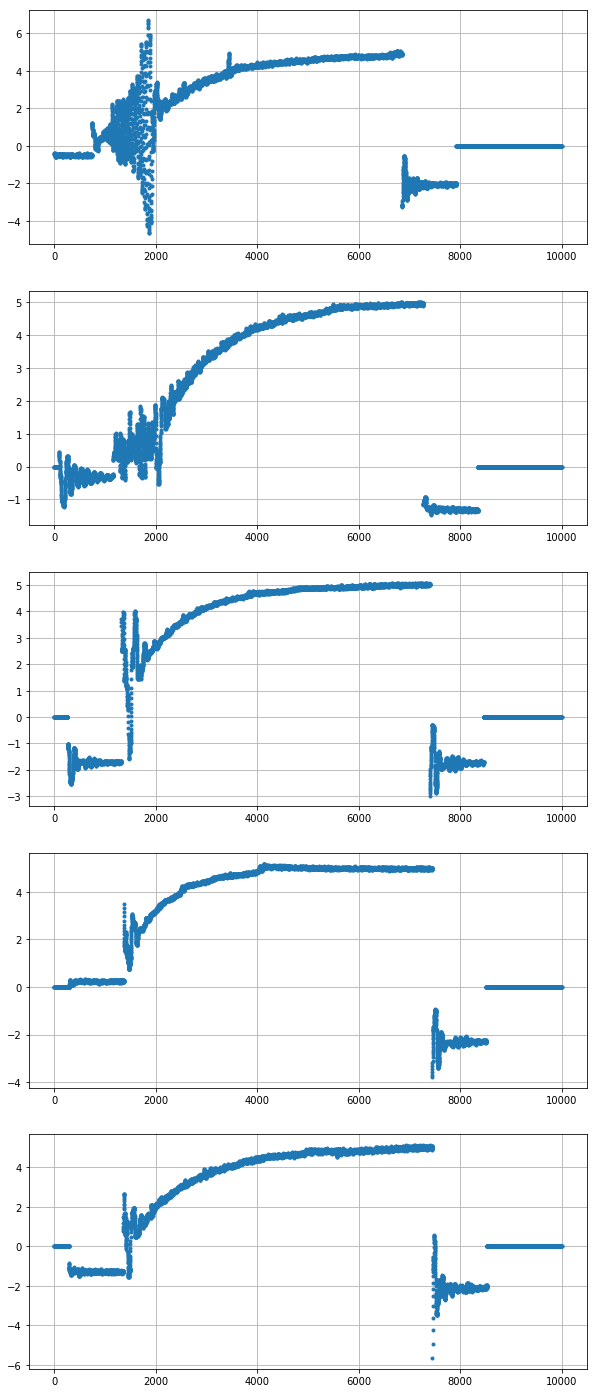

In [67]:
len_f = len(mode_switcher.force_log)
plt.figure(figsize=(10, 5*len_f))
for i in range(len_f):
    plt.subplot(len_f, 1, 1+i)
    plt.plot(mode_switcher.force_log[i][:, 0], '.')
    plt.grid()

In [68]:
DAT_DIR = os.path.join(RNB_PLANNING_DIR, "data/disinf_exp_2Y")
try_mkdir(DAT_DIR)
fpath = os.path.join(DAT_DIR, get_now()+".csv")
np.savetxt(fpath, np.array(mode_switcher.force_log)[:, :,0], delimiter=",")
save_json(fpath[:-4]+"-time.json", 
          {"time_approach_planning": time_approach_planning,
          "time_ontable_planning": time_ontable_planning})

# 사진 촬영!

# Move to home

In [69]:
inp = raw_input("Press Enter to move to home")
if inp == "":
    pmb0 = crob.robot_dict["pmb0"]
    panda_arm1 = crob.robot_dict["panda_arm1"]
    panda_arm1.joint_move_make_sure(HOME_POSE_DEFAULT[6:])
    pmb0.joint_move_make_sure([0]*6)

Press Enter to move to home


## TODO 02.06

### Detector
* 마커, 시계 현장 인식 테스트 v
* point cloud visualization 에서 0 포인트 에러 발생
* 90도 돌아간 인식

### HW
* 바퀴 높이 맞춤 90x40x6mm L shape w. profile hole x 2 뽑기
* 대형 장애물 마련하기
  - 가방? 앞뒤만 밀 수 있게 전제, 가이드레일 및 앞 범퍼 만들기
  - 의자? 방에서 미니 의자 가져와서 테스트, 다른의자 구해보기

### Planner
* 전2륜 전제로 모바일 경로 트래킹 알고리즘 보강 (늦어짐)
  - 현장 실제어주기 확인 ~15 ms
* 테이블 커버하는 view 자세/모션들 만들기

## TODO 01.31
### data
* 인식 결과 샘플 저장

### Detector
* 첫 인식에서 캐리어 4개만 인식됨 (다시 인식하면 5개 나옴)
* 마커 인식 추가

### Planner
* 바퀴가 자꾸 멈춤 - 강제로 정지되면 다이나믹셀이 셧다운 됨 - 펌웨어 수정 필요
* 플래닝 성능 개선

### Anydesk 자동 연결 설정 (소형 모니터 연결?)



In [ ]:
raise(RuntimeError("Testing script below here"))

## Testing detection 

In [ ]:
T_bt = table_g.get_tf(crob.home_pose)

In [ ]:
T_bc = viewpoint.get_tf(crob.get_real_robot_pose())

In [ ]:
T_ct = np.matmul(np.linalg.inv(T_bc), T_bt)

In [ ]:
T_tx = SE3(np.identity(3), (np.divide(table_g.dims, 2)-0.06)*[1,-1,0])
T_bx =  np.matmul(T_bt, T_tx)

In [ ]:
T_bm = gscene.get_tf(MOBILE_BASE, crob.get_real_robot_pose())

In [ ]:
T_mx = np.matmul(np.linalg.inv(T_bm), T_bx)

In [ ]:
gscene.add_highlight_axis("hl", "tbm", T=T_bm)

In [ ]:
gscene.add_highlight_axis("hl", "tmx", T=T_mx, link_name=MOBILE_BASE)

In [ ]:
gscene.clear_highlight()

In [ ]:
np.linalg.norm(T_ct[:3,3])

In [ ]:
color_img = micp.last_input[0]

In [ ]:
Rot2rpy(Rot_axis(1, -np.pi/2))

In [ ]:
 def get_aruco_map_table():
    dictionary = aruco.getPredefinedDictionary(aruco.DICT_6X6_250)
    #     params = aruco.DetectorParameters_create()
    aruco_map = ArucoMap(dictionary=dictionary, _dict={
        'table1':MarkerSet('table1', dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.4,0.3,0.01),
                          color=(0.9,0.9,0.9,0.2),
                          _list=[
                              ObjectMarker('table1', 231, 0.15, [0, 0., 0.0], (0, -0., 0.)),
#                               ObjectMarker('table', 231, 0.15, [0.7, -0.4, 0.0], (0,0,0)),
#                               ObjectMarker('table', 233, 0.15, [0.7+0.075, -0.4, 0.075], (-1.57079633, -0.,  0.))
                          ]),
        'table2':MarkerSet('table2', dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.4,0.3,0.01),
                          color=(0.9,0.9,0.9,0.2),
                          _list=[
                              ObjectMarker('table2', 232, 0.15, [0.0, 0.0, 0.0], (0,0,0)),
#                               ObjectMarker('table', 233, 0.15, [0.7+0.075, -0.4, 0.075], (-1.57079633, -0.,  0.))
                          ]),
        'table3':MarkerSet('table3', dlevel=DetectionLevel.ENVIRONMENT, gtype=GEOTYPE.BOX, dims=(0.4,0.3,0.01),
                          color=(0.9,0.9,0.9,0.2),
                          _list=[
                              ObjectMarker('table3', 233, 0.15, [0.0, 0.0, 0.0], (0,0,0)),
#                               ObjectMarker('table', 233, 0.15, [0.7+0.075, -0.4, 0.075], (-1.57079633, -0.,  0.))
                          ])})
    return aruco_map

In [ ]:
from pkg.detector.aruco.marker_config import *

aruco_map = get_aruco_map_table()

cameraMatrix, distCoeffs, _ = micp.get_camera_config()
color_img, _, Q_cur = micp.get_image()

color_img = color_img.astype(np.uint8)
obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_img, cameraMatrix, distCoeffs)
img_out = aruco_map.draw_objects(color_img, obj_dict, corner_dict, cameraMatrix, distCoeffs)

In [ ]:
# Tcm1 = obj_dict["table1"]
Tcm2 = obj_dict["table2"]
Tcm3 = obj_dict["table3"]

In [ ]:
T_bc = viewpoint.get_tf(crob.get_real_robot_pose())

In [ ]:
# Tbm1 = np.matmul(T_bc, Tcm1)
Tbm2 = np.matmul(T_bc, Tcm2)
Tbm3 = np.matmul(T_bc, Tcm3)

In [ ]:
gscene.add_highlight_axis("hl", "tbm2", T=Tbm2)
gscene.add_highlight_axis("hl", "tbm3", T=Tbm3)

In [ ]:
pmb0 = crob.robot_dict["pmb0"]

In [ ]:
Tbm0 = gscene.get_tf(MOBILE_BASE, crob.get_real_robot_pose())

In [ ]:
pmb0.joint_move_make_sure([-1.0,0,0,0,0,0])

In [ ]:
np.round(crob.get_real_robot_pose()[:6], 3)

In [ ]:
gscene.show_pose(crob.get_real_robot_pose())

In [ ]:
plt.imshow(img_out[:,:,[2,1,0]])

In [ ]:
plt.imshow(micp.last_input[0])

### temporary - robot base detection for accuracy check

In [ ]:
from pkg.detector.aruco.marker_config import *
aruco_map = get_aruco_map()
cameraMatrix, distCoeffs, _ = micp.get_camera_config()

In [ ]:
res_dict = {}
Qref = crob.get_real_robot_pose()
gscene.show_pose(Qref)

#### repeat changing Qdiff

In [ ]:
Qdiff = 0
Qnow = np.copy(Qref)
Qnow[-1] = Qref[-1] + np.deg2rad(Qdiff)
gscene.show_pose(Qnow)

In [ ]:
T = viewpoint.get_tf(Qnow)
crob.joint_move_make_sure(Qnow)
time.sleep(1)

In [ ]:
color_img, _, Q_cur = micp.get_image()
color_img = color_img.astype(np.uint8)
obj_dict, corner_dict = aruco_map.get_object_pose_dict(color_img, cameraMatrix, distCoeffs)
img_out = aruco_map.draw_objects(color_img, obj_dict, corner_dict, cameraMatrix, distCoeffs)
T_cp = obj_dict["panda1"]
T_pc = viewpoint.get_tf(crob.get_real_robot_pose(), from_link=ROBOT_BASE)
T_pp = np.matmul(T_pc, T_cp)
np.round(T_pp, 3)
res_dict[Qnow[-1]] = T_pp

In [ ]:
qxyz = np.array([(q, T_pp[0,3], T_pp[1,3], T_pp[2,3])  for q, T_pp in sorted(res_dict.items())])
plt.plot(np.rad2deg(qxyz[:,0]), qxyz[:,1], '-o')
plt.plot(np.rad2deg(qxyz[:,0]), qxyz[:,2], '-o')
plt.plot(np.rad2deg(qxyz[:,0]), qxyz[:,3], '-o')
plt.legend("xyz")

### temporary - robot base detection for accuracy check

### change controller

In [ ]:
# wc.change_controller("Hybrid_Null")
wc.change_controller("NRIC_PD")

### backup joint offset

In [ ]:
q_off_bak = wc.gain_listed_dict["q_off"]
q_off_bak

### set joint offset 0

In [ ]:
wc.change_gain(**{"q_off{}".format(i_q):0 for i_q, q_off in enumerate(q_off_bak)})

### restore joint offset

In [ ]:
wc.change_gain(**{"q_off{}".format(i_q):q_off for i_q, q_off in enumerate(q_off_bak)})

### change control mode

In [ ]:
wc.change_gain(switch_control0=0)